# TP6 : Inpainting

In [2]:
%pylab inline
gray() # pour afficher toutes les images en noir et blanc
figsize(16,8) #pour afficher les images en grand format

Populating the interactive namespace from numpy and matplotlib


Dans ce TP, nous nous intéressons à un problème de reconstruction d'images. Une image *noir et blanc* peut-être vue comme une matrice $I \in M_{h \times w}(\mathbb{R})$, où $I_{ij}$ représente l'intensité du pixel situé en $(i,j)$ (avec les conventions de l'origine qui peuvent être celles des matrices, ou celles des images, suivant votre préférence). Ici $w$ est la largeur (*width*) de l'image, et $h$ est la hauteur (*height*).

De manière générale, $I[i,j] := I_{ij}$ est un réel compris entre $0$ et $1$, où $0$ est la couleur *noir*, et $1$ est la couleur *blanche*.

Télécharger le fichier **TP6_Image.png** et le fichier **TP6_Masque.png**. 

On peut afficher lire et afficher les images avec les commandes suivantes.

**Note** : *Si l'image s'affiche en petit, recompiler la toute première cellule !*

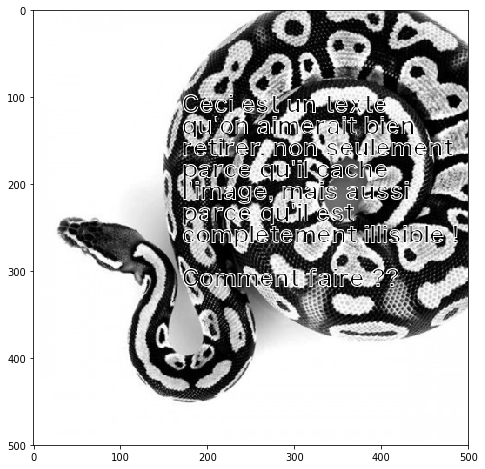

In [3]:
Im = imread('TP6_Image.png')
imshow(Im)

**Exercice** : Quelle est la taille de l'image ? Si chaque pixel représente une variable, combien y a-t-il de variables au total ? Montrer que l'image peut être vu comme un vecteur de taille environ 250000.

Ici, notre image en noir et blanc et en fait une matrice. Elle s'affiche comme une image grâce à la commande `imshow`. En pratique, une image couleur est un ensemble de 3 telles matrices (une pour les couleurs rouge, vert et bleu).

**Exercice** : Créer une image aléatoire `Im_alea` de même taille que `Im`, où tous les coefficients sont tirés aléatoirement uniformément entre $0$ et $1$, et afficher cette image.
- On pourra utiliser la fonction `rand`

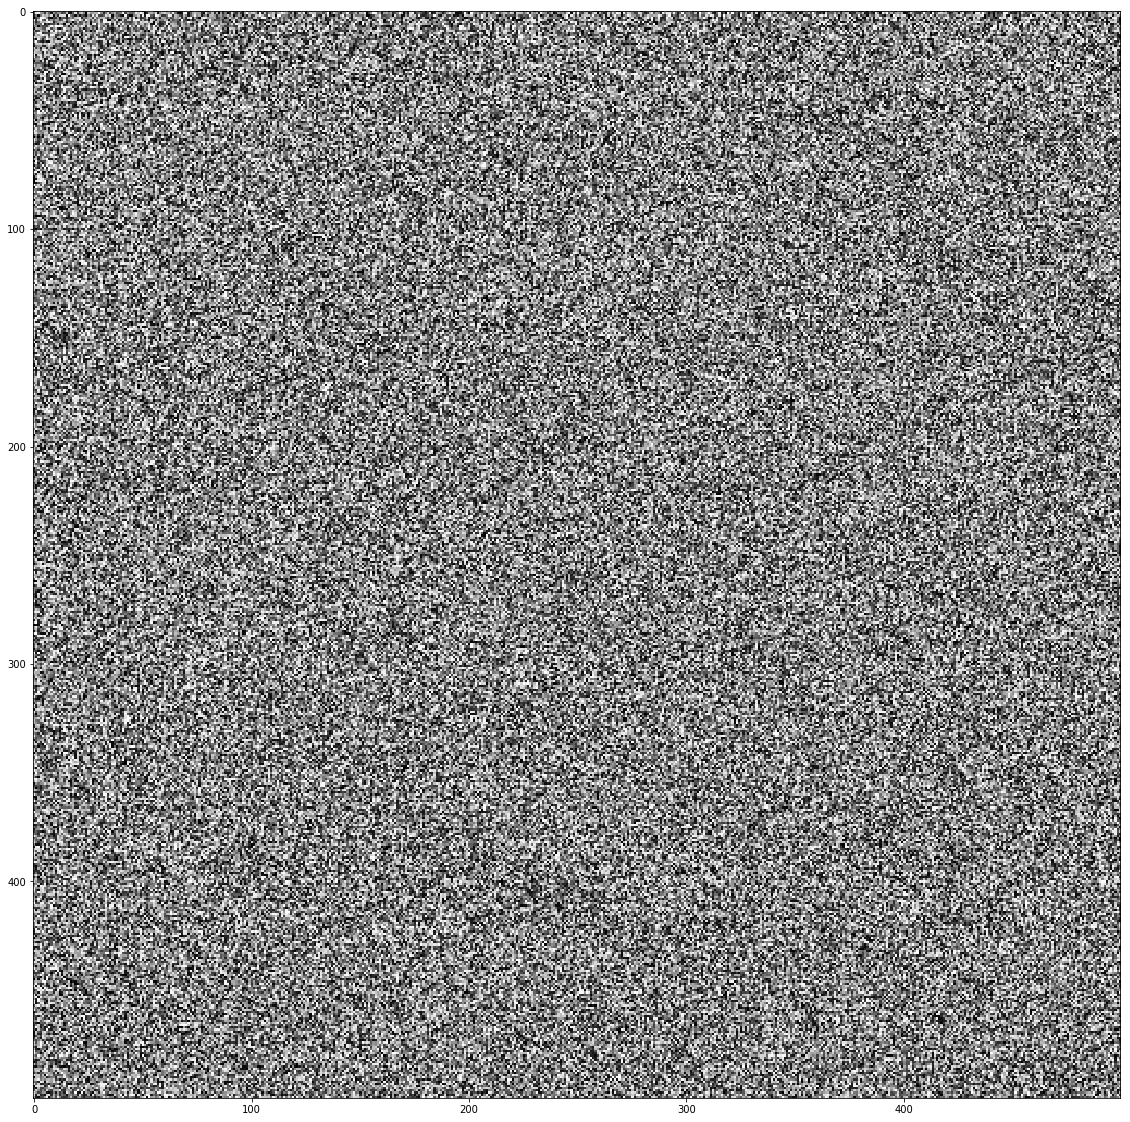

In [16]:
h,w = shape(Im)
Im_alea = rand(h,w)
imshow(Im_alea)

## 1. Les dérivées d'une image

Soit $I$ de taille $h \times w$. On appelle *Laplacien de $I$* l'image $\Delta_I$ de taille $h \times w$ telle que
$$
    \left( \Delta_I \right)[i,j] := I[i+1,j] + I[i-1, j] + I[i,j+1] + I[i,j-1] - 4I[i,j]
$$
Ici, on suppose que l'image est *périodique*, dans le sens où tous les indices sont calculés modulo $h$ ou $w$.

**Exercice** : Montrer que $\Delta : I \mapsto \Delta_I$ est un opérateur linéaire de $\mathbb{R}^{h\times w}$ dans $\mathbb{R}^{h\times w}$. Si on représente l'opérateur $\Delta$ par une matrice, de quelle taille serait cette matrice ? Quel est le problème ?

**Exercice** : Ecrire une fonction `Delta(I)` qui prend une image `I` et renvoie `\Delta_I`.
- On pourra/devra utiliser la fonction `roll`
- **pas de boucle for** (un code avec la boucle for est environ 60x plus long)

In [17]:
def Delta(I):
    Ix = roll(I,1,1) + roll(I,-1,1) - 2*I
    Iy = roll(I,1,0) + roll(I,-1,0) - 2*I
    return Ix + Iy

**Exercice** : Afficher le Laplacien de l'image initiale, et le Laplacien de l'image aléatoire. Que se passe-t-il ? Pouvez-vous expliquer ce phénomène ?
- On pourra utiliser la commande `subplot` pour afficher des images côte à côte (cf google)

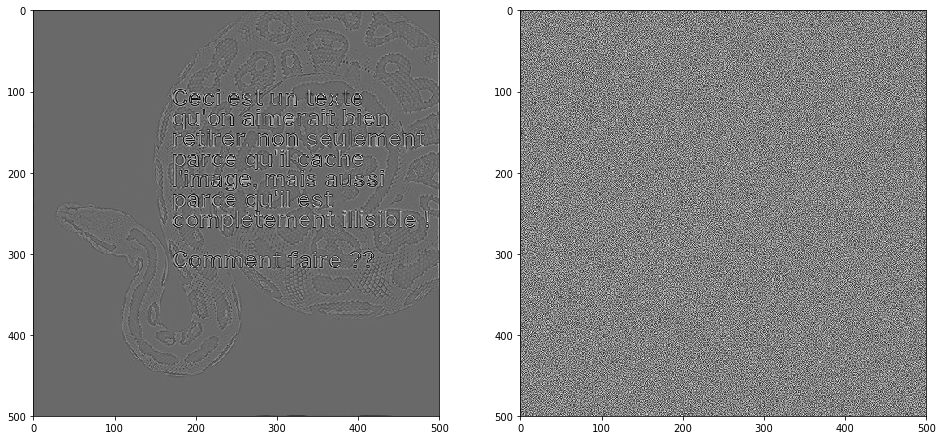

In [6]:
subplot(121)
imshow(Delta(Im))
subplot(122)
imshow(Delta(Im_alea))

# Le Laplacien de l'image aléatoire est encore aléatoire (évidemment)
# Mais le Laplacien de l'image initiale est presque uniforme.
# Cela vient du fait que si des pixels voisins de la même couleur, alors le Laplacien est petit dans cette zone.

On appelle *énergie $H_1$* de l'image $I$ le nombre réel
$$
    H_1(I) :=  \left[\sum_{i,j} \left( \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 \right) \right]^{1/2}.
$$

**Exercice (!) **: Montrer que 
$$
    \left[ H_1(I) \right]^2 = - \langle I, \Delta_I \rangle_{\mathbb{R}^{h \times w}} = - \sum_{i,j} I[i,j] \times \Delta_I[i,j]
$$

On rappelle qu'en Python, la commande `C = A*B` renvoie la matrice $C := A \odot B$ telle que $C_{i,j} = A_{i,j} B_{i,j}$.

**Exercice** : Ecrire une fonction `H1(I)` qui calcule l'énergie $H_1$ de l'image $I$. Calculer `H1(Im)` et `H1(Im_alea)`. Que remarquez-vous ?

In [68]:
def H1(I) : 
    return sqrt(-sum(I*Delta(I)))
def H1bis(I) : 
    return sqrt(sum( (roll(I,1,1) - I)**2 + (roll(I,1,0) - I)**2))

print("H1(Im) = ", H1(Im))
print("H1(Im_alea) = ", H1(Im_alea))
print('''On observe un facteur 3 entre l'énergie H1 d'une image "normale", et celle d'une image aléatoire.''')

H1(Im) =  80.5412
H1(Im_alea) =  288.762693349
On observe un facteur 3 entre l'énergie H1 d'une image "normale", et celle d'une image aléatoire.


In [69]:
#Vérification, ne pas modifier
assert( abs(H1(Im) - 80.5412) < 1e-3) , "problème dans la fonction H1"

Dans la suite, on fera l'hypothèse que l'énergie $H_1$ permet de *détecter les vraies images*. Pour restaurer une image, on cherchera donc à minimiser cette énergie.

** Exercice ** : Quel est le minimum de $H_1$ ? Pour quelles images ce minimum est-il atteint ? Pourquoi faut-il imposer des contraintes pour restaurer des images en minimisant $H_1$ ?

## 2. Projection sur la contrainte

Dans la méthode *inpainting*, on sait exactement quelle zone on veut *restaurer*. Cela signifie qu'on sait quels pixels doivent être modifiés, et quels pixels doivent rester constant. Autrement dit, on a accès à un *masque* M.

Dans notre cas par exemple, on voudrait retirer le texte de l'image, et éventuellement les coupures verticales. On utilisera le masque **TP6_Masque.png**.

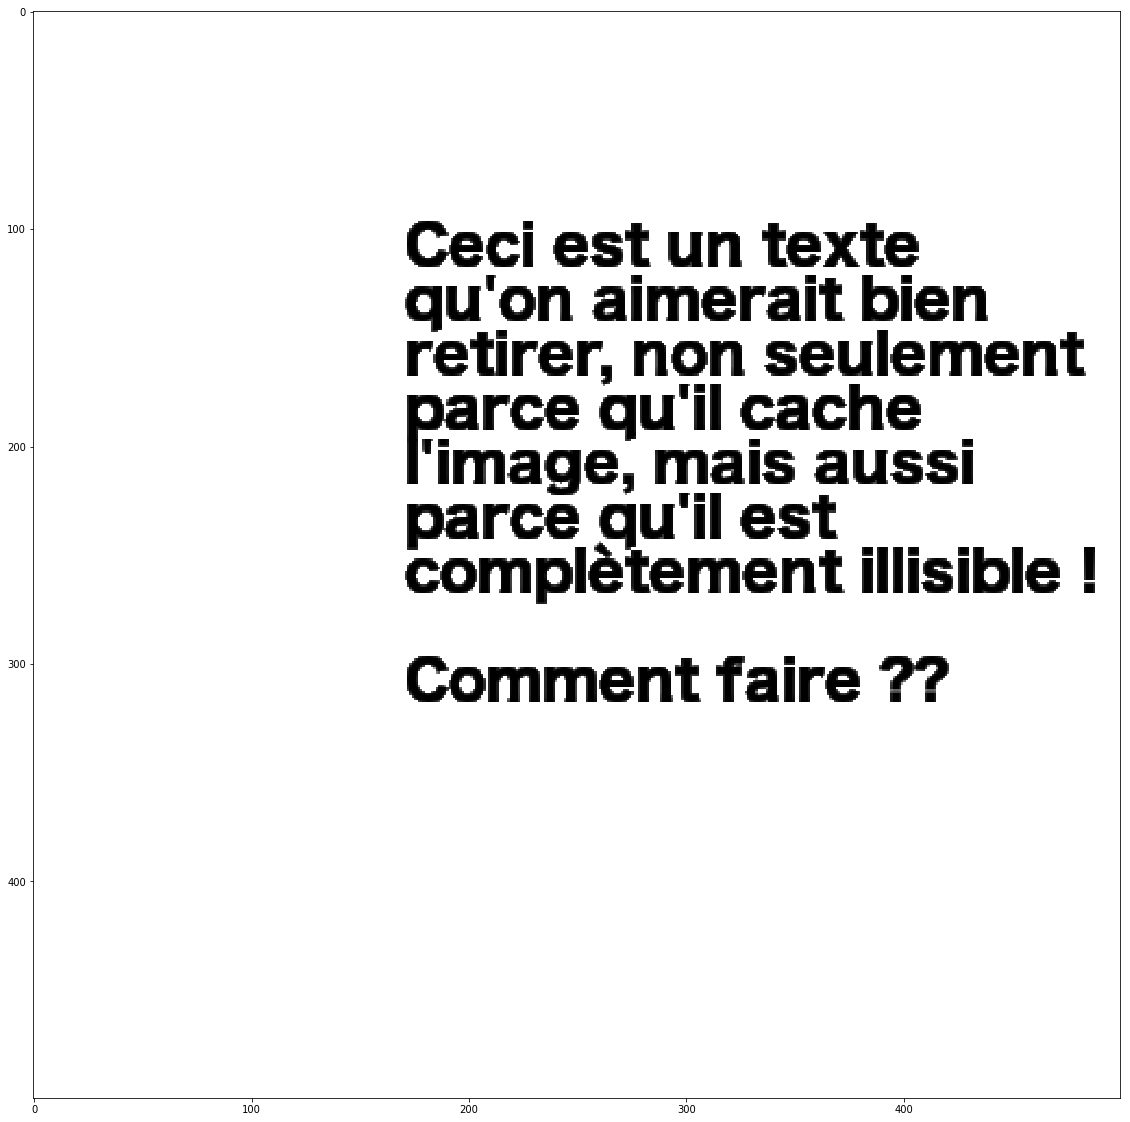

In [20]:
M = imread('TP6_Masque.png')
imshow(M)

On notera que les pixels du masque vérifie $M[i,j] = 1$ (blanc) si le pixel est déjà bien, et vaut $M[i,j] = 0$ s'il doit être modifié (noir).


Soit $I$ une image quelconque. On appelle *projection de I* l'image $P(I)$ telle que
$$
    P(I) [i,j] := \begin{cases} {\rm Im}[i,j] \quad \text{si} \quad M[i,j] = 1 \\
        I[i,j] \quad \text{sinon}.
        \end{cases}  
$$
On notera que la projection dépend de l'image initiale `Im` et du masque `M`.

**Exercice** : Montrer que $P(I) = M \odot Im + (1 - M) \odot I$.

**Exercice** : Ecrire une fonction `P(I)` qui renvoie la projection de l'image $I$, puis afficher `P(Im_alea)`.

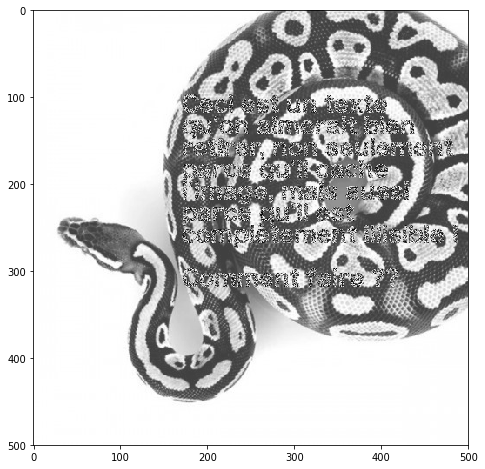

In [10]:
def P(I):
    return M*Im + (1-M)*I
imshow(P(Im_alea))

**Exercice** : Montrer que l'application $I \mapsto P(I)$ est affine de $\mathbb{R}^{h \times w}$ dans $\mathbb{R}^{h \times w}$, puis que $P \circ P = P$ (donc $P$ est bien une projection).

## 3. Méthode du gradient projeté

Dans la méthode du gradient projeté, on veut minimiser $H_1(I)$ sous la contrainte que $I = P(I)$, ce qui équivalent à dire que $I$ est dans l'image de $P$, ou encore les bons pixels de $I$ sont les pixels de `Im`.

L'idée est de faire une descente de gradient à pas constant $\tau$, et de projeter les itérations avec $P$. Autrement dit
$$
    I_{n+1} = P \left( I_n - \tau \nabla H_1(I_n) \right).
$$

Pour faire cela, on commence par calculer le gradient de $H1$. On fera attention qu'en parlant de gradient, on voit ici les images comme des vecteurs de $\mathbb{R}^{h \times w}$, où on a juste "trié" les éléments sous forme d'une image.

**Exercice** : Montrer que
$$
    \nabla H_1(I) = \dfrac{- \Delta_I}{\sqrt{- \langle I, \Delta_I \rangle}}.
$$
**Exercice** : Ecrire une fonction `dH1(I)` qui renvoie le gradient de $H_1$ en $I$.

In [11]:
def dH1(I):
    DeltaI = Delta(I)
    return 1/sqrt(-sum(I*DeltaI))*(-DeltaI)

**Exercice** : Ecrire une fonction `gradientProjete(dH, I0, tau, tol=1e-4, Niter=200)` qui calcule les itérations du gradient projeté en partant de $I_0$. 
- On pourra s'arrêter lorsque `norm(Inp1 - In) < tol`.

In [12]:
def gradientProjete(dH, I0, tau, tol=1e-4, Niter=200):
    In = I0
    for n in range(Niter):
        Inp1 = P( In-tau*dH(In) )
        if norm(Inp1 - In) < tol:
            return Inp1
        In = Inp1
    print("Problème, l'algorithme n'a pas convergé après", Niter, "itérations")
    return Inp1

**Exercice** : Tester votre fonction, et afficher le résultat.
- On pourra prendre `tau = 10`.

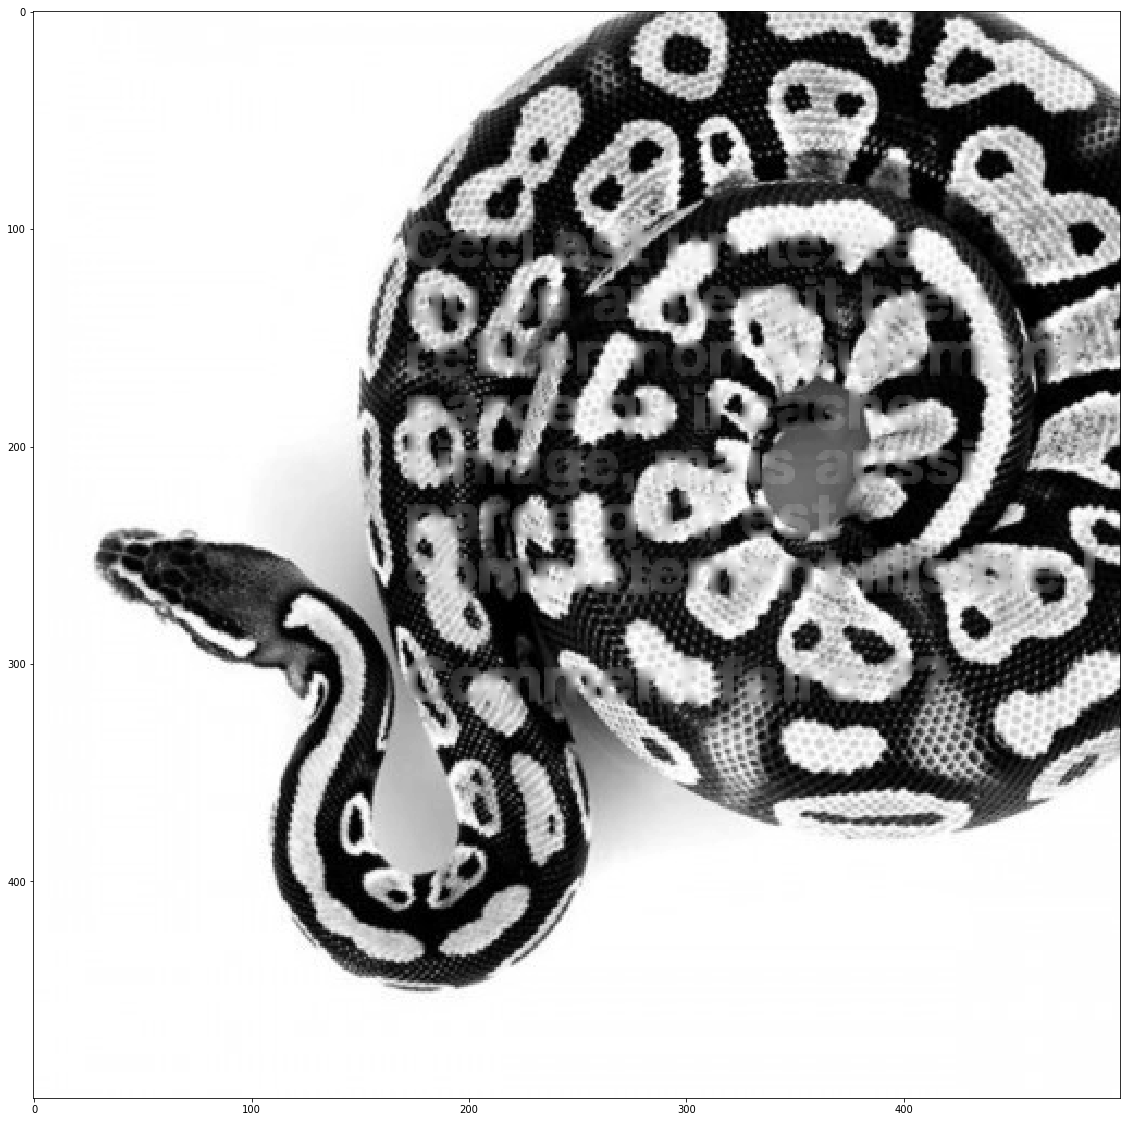

In [15]:
Istar = gradientProjete(dH1, Im,10)
imshow(Istar)

## 4. Pour aller plus loin, la variation totale

La minimisation de $H_1$ donne déjà des résultats assez convaincants. Cependant, on arrive encore à lire le texte. On cherche maintenant une autre fonctionnelle à minimiser. On peut regarder par exemple la fonctionelle suivante, appelée *variation totale* (total variation)
$$
    TV(I) :=  \sum_{i,j} \sqrt{ \delta + \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 }.
$$
Notez que la position de la racine carrée a changé. Ici, $\delta > 0$ est un petit paramètre pour dériver la racine.

**Exercice** : Ecrire une fonction `TV(I)` qui renvoie la variation totale de l'image $I$, et calculer la variation totale de l'image initiale et de l'image aléatoire.
- on prendra `delta = 1e-1`.

In [31]:
delta = 1e-1
def TV(I):
    return sum(sqrt(delta + (roll(I,-1,0) - I)**2 + (roll(I,-1,1) - I)**2))
print("TV(Im) = ", TV(Im))
print("TV(Im_alea) = ", TV(Im_alea))

TV(Im) =  86490.4
TV(Im_alea) =  155865.407452


**Exercice (!) ** : Montrer que le gradient de $TV$ en $I$ et donné par
\begin{align*}
    \dfrac{\partial TV(I)}{\partial I[i,j]} = & 
    \dfrac{2 I[i,j] - I[i+1, j] - I[i, j+1]}{\sqrt{ \delta + \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 }} \\
    & \quad +
    \dfrac{I[i,j] - I[i-1, j]}{\sqrt{ \delta + \big| I[i,j] - I[i-1,j] \big|^2 + \big| I[i-1,j+1] - I[i-1,j] \big|^2 }} \\
    & \quad + 
    \dfrac{I[i,j] - I[i, j-1]}{\sqrt{ \delta + \big| I[i,j-1] - I[i+1,j-1] \big|^2 + \big| I[i,j] - I[i,j-1] \big|^2 }}.
\end{align*}

**Exercice** : Ecrire une fonction `dTV(I)` qui renvoie ce gradient. 
- On fera attention à ne pas utiliser de boucles !

In [52]:
def dTV(I):
    J1 = (2*I - roll(I,-1,0) - roll(I,-1,1))/sqrt(delta + (roll(I,-1,0) - I)**2 + (roll(I,-1,1) - I)**2)
    Iim1 = roll(I,1, 0)
    J2 = (I - Iim1)/sqrt(delta + (I - Iim1)**2 + (roll(Iim1, -1, 1) - Iim1)**2)
    Ijm1 = roll(I,1, 1)
    J3 = (I - Ijm1)/sqrt(delta + (Ijm1 - roll(Ijm1, -1, 0))**2 + (I - Ijm1)**2)
    return J1 + J2 + J3

**Exercice** Afficher les images `dTV(Im)` et `dTV(Im_alea)`. Qu'observez-vous ?

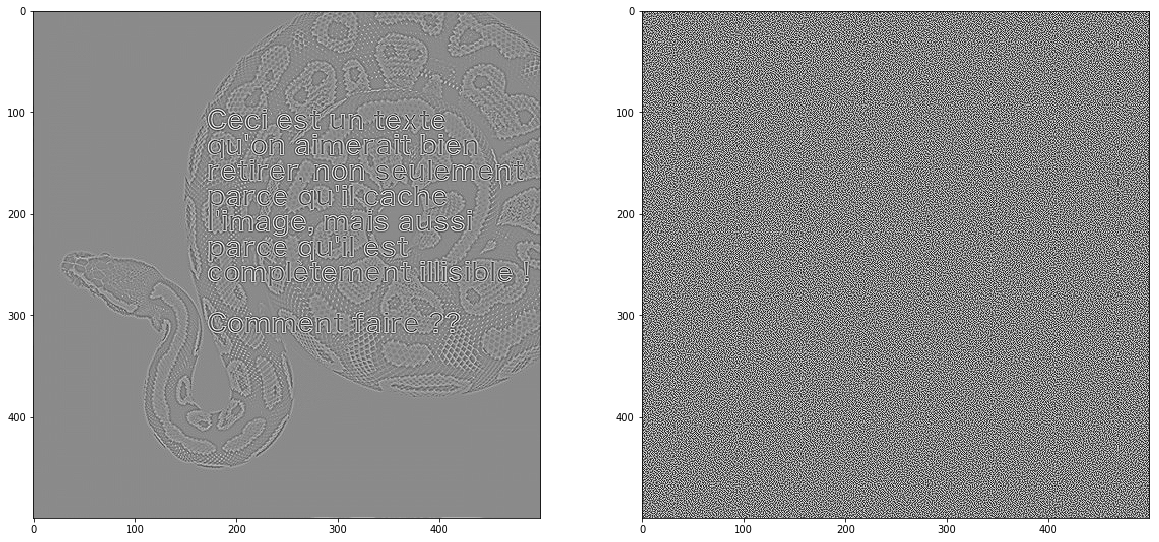

In [53]:
subplot(121)
imshow(dTV(Im))
subplot(122)
imshow(dTV(Im_alea))

**Exercice** : Afficher côte à côte les images `dTV(I)` et `Delta(I)`. Qu'en pensez-vous ?

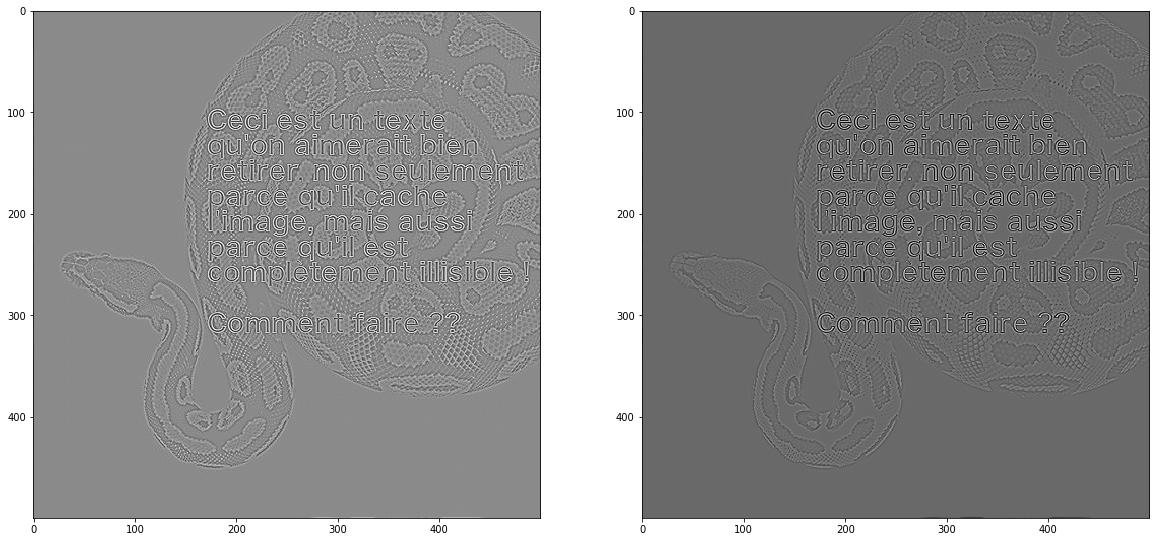

In [54]:
subplot(121)
imshow(dTV(Im))
subplot(122)
imshow(Delta(Im))

** Exercice ** : tester le gradient projeté avec l'énergie TV. Que pensez-vous du résultat ?
- On pourra prendre `tau = 0.05`

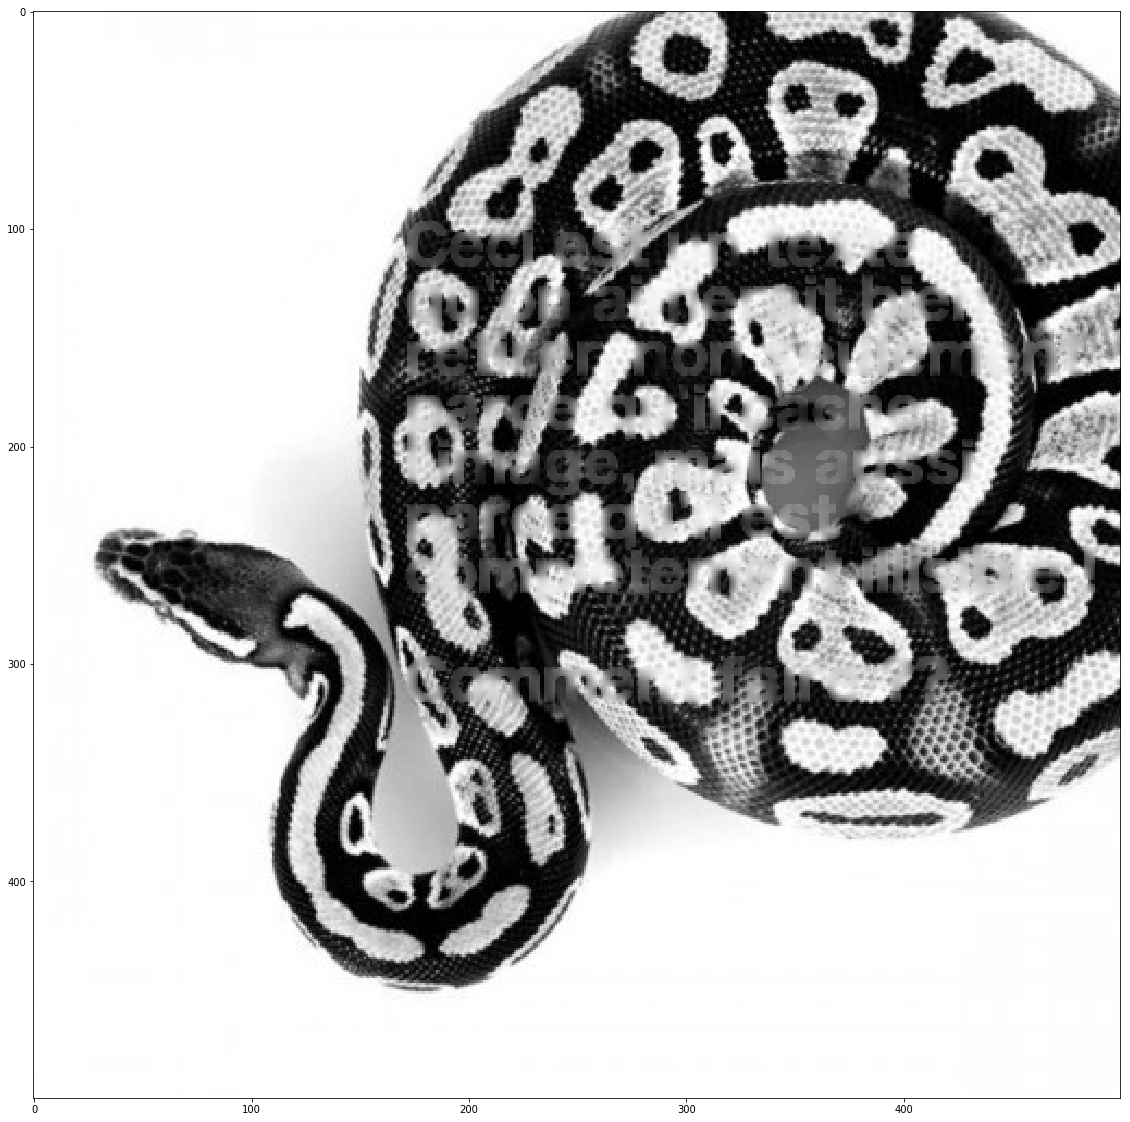

In [66]:
IstarTV = gradientProjete(dTV, Istar, 0.05, tol=1e-10, Niter=1000)
imshow(IstarTV)

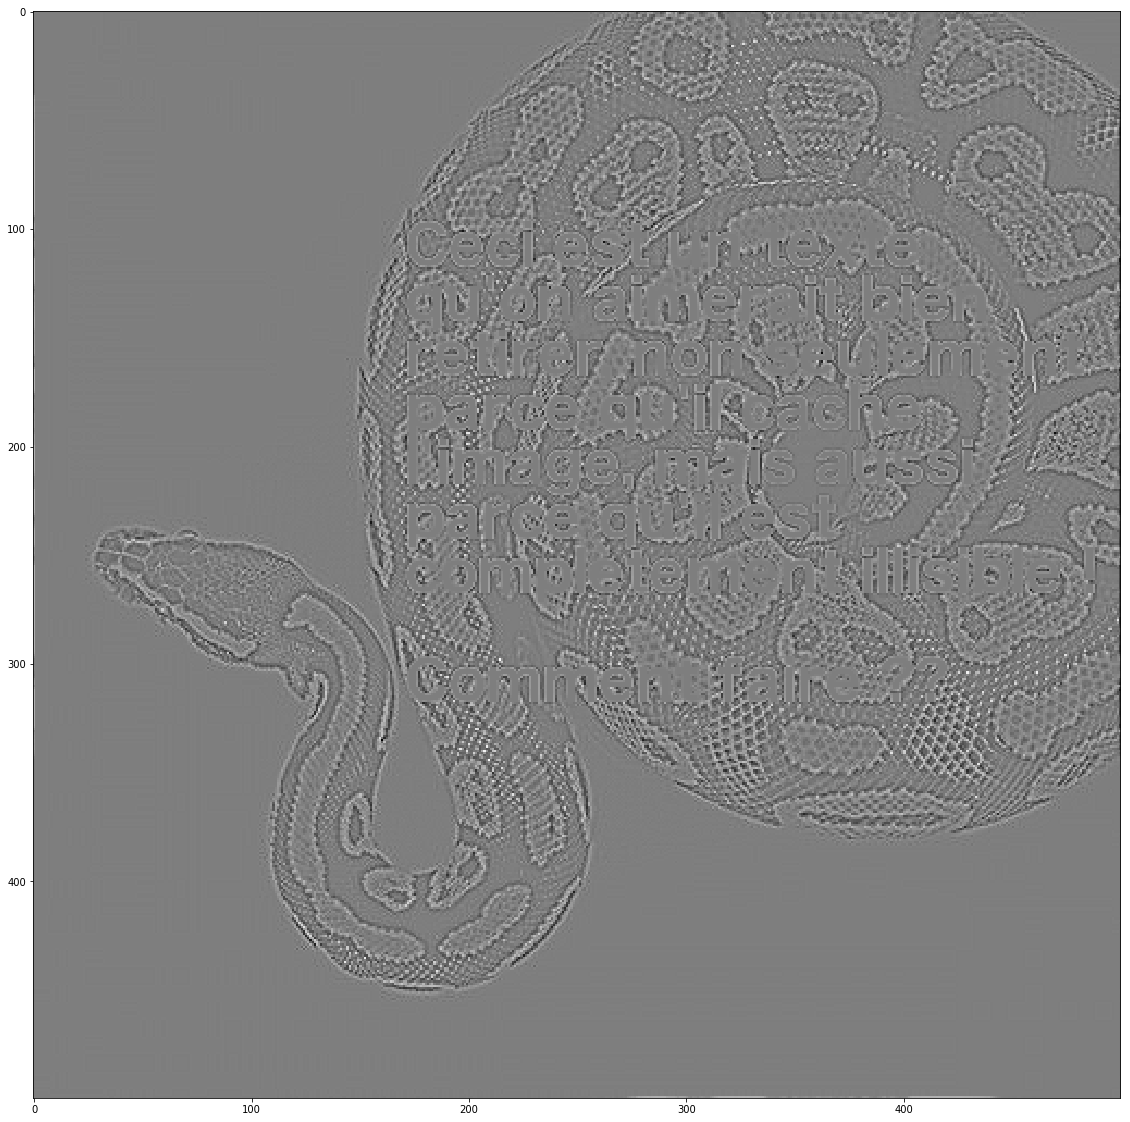

In [67]:
imshow(dTV(IstarTV))